# Value and Bivariate Sorts

2024.12

本章将单变量投资组合分析扩展到双变量排序，利用公司规模与账面市值比，先后采用独立排序和从属排序的方法形成不同的投资组合，并对其收益率进行比较

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import sqlite3
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import percent_format, date_format
import warnings
warnings.filterwarnings("ignore")

In [2]:
#导入数据
tidy_finance = sqlite3.connect(database="/Users/yy/Desktop/pythonProject/finance/tidy_finance.sqlite")

crsp_monthly = (pd.read_sql_query(
    sql=("SELECT permno, gvkey, date, ret_excess, mktcap, " 
         "mktcap_lag, exchange FROM crsp_monthly"),
    con=tidy_finance,
    parse_dates={"date"})
  .dropna()
)

In [3]:
crsp_monthly
#permno（股票标识符）、gvkey（公司标识符）、date（日期）、ret_excess（超额收益）、mktcap（市值）、
#mktcap_lag（市值的滞后值）、exchange（交易所）

,permno,gvkey,date,ret_excess,mktcap,mktcap_lag,exchange
0,10028,012096,1993-03-01,-0.102500,6.329250,7.032500,AMEX
1,10028,012096,1993-04-01,0.386489,8.790625,6.329250,AMEX
2,10028,012096,1993-05-01,0.197800,10.548750,8.790625,AMEX
3,10028,012096,1993-06-01,-0.135833,9.044750,10.548750,AMEX
4,10028,012096,1993-07-01,0.189908,10.784125,9.044750,AMEX
...,...,...,...,...,...,...,...
3326348,10042,012139,2005-02-01,-0.215192,23.583960,29.989479,AMEX
3326349,10042,012139,2005-03-01,-0.113211,21.029761,23.583960,AMEX
3326350,10042,012139,2005-04-01,-0.071544,19.569360,21.029761,AMEX
3326351,10042,012139,2005-05-01,0.102078,25.538140,19.569360,AMEX


In [4]:
#导入会计数据，调整日期格式
book_equity = (pd.read_sql_query(
    sql="SELECT gvkey, datadate, be FROM compustat",
    con=tidy_finance, 
    parse_dates={"datadate"})
  .dropna()
  .assign(
    date=lambda x: (
      pd.to_datetime(x["datadate"]).dt.to_period("M").dt.to_timestamp()
    )
  )
)
book_equity

,gvkey,datadate,be,date
0,006260,1960-01-31,57.680,1960-01-01
3,005410,1960-01-31,14.880,1960-01-01
4,004611,1960-01-31,240.827,1960-01-01
7,001301,1960-01-31,162.510,1960-01-01
9,008150,1960-01-31,17.380,1960-01-01
...,...,...,...,...
549420,180229,2022-12-31,204.733,2022-12-01
549421,064766,2022-12-31,804.261,2022-12-01
549422,036776,2022-12-31,60.732,2022-12-01
549424,029914,2022-12-31,58.866,2022-12-01


在形成投资组合时，投资者的考量不能包含当时并未获得的数据，因此必须对会计信息进行滞后处理。

先将市值和公司规模滞后一个月。

In [5]:
me = (crsp_monthly
  .assign(sorting_date=lambda x: x["date"]+pd.DateOffset(months=1))
  .rename(columns={"mktcap": "me"})
  .get(["permno", "sorting_date", "me"])
)

计算账面市值比率（book-to-market ratio），即公司账面股权与市场股权的比值。账面市值比率较高的公司被称为价值型公司，账面市值比率较低的公司被称为成长型公司。
在将会计信息与市场股权信息按同一月份匹配后，我们将账面市值比率滞后六个月（会计信息通常在六个月前发布）。

In [6]:
bm = (book_equity
  .merge(crsp_monthly, how="inner", on=["gvkey", "date"])
  .assign(bm=lambda x: x["be"]/x["mktcap"],
          sorting_date=lambda x: x["date"]+pd.DateOffset(months=6))
  .assign(comp_date=lambda x: x["sorting_date"])
  .get(["permno", "gvkey", "sorting_date", "comp_date", "bm"])
)

得到市值滞后一个月和账面市值比率滞后六个月后将这些排序变量与收益数据合并，创建“sorting_date”列。

In [7]:
data_for_sorts0 = (crsp_monthly
  .merge(bm, 
         how="left", 
         left_on=["permno", "gvkey", "date"], 
         right_on=["permno", "gvkey", "sorting_date"])
  .merge(me, 
         how="left", 
         left_on=["permno", "date"], 
         right_on=["permno", "sorting_date"])
  .get(["permno", "gvkey", "date", "ret_excess", 
        "mktcap_lag", "me", "bm", "exchange", "comp_date"])
)

数据准备的最后一步是处理变量的频率差异：
收益和公司规模是按月记录的，而会计信息仅按年发布。因此，我们每年只会匹配一个月的账面市值比率，并且会有11个空缺的观测值。
为了解决这个频率问题，我们将每个公司的最新账面市值比率带入后续月份，即使用最新的报告填补缺失的观测值。
通过对数据按日期和公司排序后使用ffill函数来实现，其中会过滤掉所有会计数据早于一年的观测值。
最后一步是删除所有没有匹配到年报的行，因为这些行无法与收益数据匹配。

In [8]:
data_for_sorts = (data_for_sorts0
  .sort_values(by=["permno", "gvkey", "date"])
  .groupby(["permno", "gvkey"],group_keys=False,observed=False)
  .apply(lambda x: x.assign(
      bm=x["bm"].ffill(), 
      comp_date=x["comp_date"].ffill()
    )
  )
  .reset_index(drop=True)
  .assign(threshold_date = lambda x: (x["date"]-pd.DateOffset(months=12)))
  .query("comp_date > threshold_date")
  .drop(columns=["comp_date", "threshold_date"])
  .dropna()
)

In [9]:
data_for_sorts

,permno,gvkey,date,ret_excess,mktcap_lag,me,bm,exchange
14,10000,013007,1987-04-01,-0.066900,0.973250,0.973250,0.139225,NASDAQ
15,10000,013007,1987-05-01,-0.070467,0.912422,0.912422,0.139225,NASDAQ
26,10001,012994,1986-12-01,0.010100,6.937000,6.937000,1.166394,NASDAQ
27,10001,012994,1987-01-01,-0.039914,6.937000,6.937000,1.166394,NASDAQ
28,10001,012994,1987-02-01,-0.078374,6.689250,6.689250,1.166394,NASDAQ
...,...,...,...,...,...,...,...,...
3097032,93436,184996,2022-08-01,-0.074389,931110.623250,931110.623250,0.027663,NASDAQ
3097033,93436,184996,2022-09-01,-0.039489,863615.620800,863615.620800,0.027663,NASDAQ
3097034,93436,184996,2022-10-01,-0.144468,837659.500000,837659.500000,0.027663,NASDAQ
3097035,93436,184996,2022-11-01,-0.147226,718514.868879,718514.868879,0.027663,NASDAQ


最后准备步骤是计算断点。使用和前一章相同的函数，允许指定用于计算断点的交易所。
此外引入了参数sorting_variable，用于定义不同的排序变量。

In [10]:
def assign_portfolio(data, exchanges, sorting_variable, n_portfolios):
    breakpoints = (data
      .query(f"exchange in {exchanges}")
      .get(sorting_variable)
      .quantile(np.linspace(0, 1, num=n_portfolios+1), interpolation="linear")
      .drop_duplicates()
    )
    breakpoints.iloc[0] = -np.Inf
    breakpoints.iloc[breakpoints.size-1] = np.Inf
    
    assigned_portfolios = pd.cut(
      data[sorting_variable],
      bins=breakpoints,
      labels=range(1, breakpoints.size),
      include_lowest=True,
      right=False
    )
    
    return assigned_portfolios

## 独立排序

   双变量排序在由两个排序变量构成的二维空间中创建投资组合，然后评估任一排序变量的回报影响，方法是通过计算排序变量两端投资组合的交易策略的回报差异，即价值溢价（高账面市值比率和低账面市值比率公司之间的回报差异）。
    
   使用账面市值比率和公司规模作为排序变量，创建一个五乘五的矩阵，最终得到25个投资组合。关注价值溢价，做多账面市值比率最高的五个投资组合，做空账面市值比率最低的五个投资组合。

   为了实现独立的双变量投资组合排序，我们分别为每个排序变量分配每月的投资组合，分别生成portfolio_bm和 portfolio_me变量，然后将这些独立的投资组合合并到最终的排序中。在生成投资组合后，计算每个月内每个投资组合的平均回报（按市值加权）。

In [51]:
#独立排序
value_portfolios_bm = (data_for_sorts
  .groupby("date",group_keys=False,observed=False)
  .apply(lambda x: x.assign(
      portfolio_bm=assign_portfolio(
        data=x, sorting_variable="bm", n_portfolios=5, exchanges=["NYSE"]
      )
    )
  )
  .reset_index(drop=True)
)

In [52]:
value_portfolios_bm

,permno,gvkey,date,ret_excess,mktcap_lag,me,bm,exchange,portfolio_bm
0,10000,013007,1987-04-01,-0.066900,0.973250,0.973250,0.139225,NASDAQ,1
1,10000,013007,1987-05-01,-0.070467,0.912422,0.912422,0.139225,NASDAQ,1
2,10001,012994,1986-12-01,0.010100,6.937000,6.937000,1.166394,NASDAQ,4
3,10001,012994,1987-01-01,-0.039914,6.937000,6.937000,1.166394,NASDAQ,4
4,10001,012994,1987-02-01,-0.078374,6.689250,6.689250,1.166394,NASDAQ,4
...,...,...,...,...,...,...,...,...,...
2653298,93436,184996,2022-08-01,-0.074389,931110.623250,931110.623250,0.027663,NASDAQ,1
2653299,93436,184996,2022-09-01,-0.039489,863615.620800,863615.620800,0.027663,NASDAQ,1
2653300,93436,184996,2022-10-01,-0.144468,837659.500000,837659.500000,0.027663,NASDAQ,1
2653301,93436,184996,2022-11-01,-0.147226,718514.868879,718514.868879,0.027663,NASDAQ,1


In [53]:
value_portfolios_me = (data_for_sorts
  .groupby("date",group_keys=False,observed=False)
  .apply(lambda x: x.assign(
       portfolio_me=assign_portfolio(
        data=x, sorting_variable="me", n_portfolios=5, exchanges=["NYSE"]
      )
    )
  )
  .reset_index(drop=True)
)

In [14]:
value_portfolios_me

,permno,gvkey,date,ret_excess,mktcap_lag,me,bm,exchange,portfolio_me
0,10000,013007,1987-04-01,-0.066900,0.973250,0.973250,0.139225,NASDAQ,1
1,10000,013007,1987-05-01,-0.070467,0.912422,0.912422,0.139225,NASDAQ,1
2,10001,012994,1986-12-01,0.010100,6.937000,6.937000,1.166394,NASDAQ,1
3,10001,012994,1987-01-01,-0.039914,6.937000,6.937000,1.166394,NASDAQ,1
4,10001,012994,1987-02-01,-0.078374,6.689250,6.689250,1.166394,NASDAQ,1
...,...,...,...,...,...,...,...,...,...
2653298,93436,184996,2022-08-01,-0.074389,931110.623250,931110.623250,0.027663,NASDAQ,5
2653299,93436,184996,2022-09-01,-0.039489,863615.620800,863615.620800,0.027663,NASDAQ,5
2653300,93436,184996,2022-10-01,-0.144468,837659.500000,837659.500000,0.027663,NASDAQ,5
2653301,93436,184996,2022-11-01,-0.147226,718514.868879,718514.868879,0.027663,NASDAQ,5


In [15]:
value_portfolios_combined = pd.merge(value_portfolios_bm, value_portfolios_me, how="inner")
value_portfolios = (value_portfolios_combined
  .groupby(["date", "portfolio_bm", "portfolio_me"],group_keys=False, observed=False)
  .apply(lambda x: pd.Series({
      "ret": np.average(x["ret_excess"], weights=x["mktcap_lag"])
    })
  )
  .reset_index()
)

   在获得每月的投资组合回报的分组后，可以开始计算高账面市值比率投资组合与低账面市值比率投资组合之间的回报差异，并得出平均而言的价值溢价。

In [16]:
#账面市值比的价值溢价
value_premium = (value_portfolios
  .groupby(["date", "portfolio_bm"],group_keys=False,observed=False)
  .aggregate({"ret": "mean"})
  .reset_index()
  .groupby("date",group_keys=False,observed=False)
  .apply(lambda x: pd.Series({
    "value_premium": (
        x.loc[x["portfolio_bm"] == x["portfolio_bm"].max(), "ret"].mean() - 
          x.loc[x["portfolio_bm"] == x["portfolio_bm"].min(), "ret"].mean()
      )
    })
  )
  .aggregate({"value_premium": "mean"})
)
value_premium_yearly = value_premium*12

In [17]:
value_premium,value_premium_yearly

(value_premium    0.004312
 dtype: float64,
 value_premium    0.051747
 dtype: float64)

   高账面市值比的投资组合比低账面市值比的投资组合平均每月超额收益要多0.004312，每年要多0.051747，整体上超额收益更高。

## 依赖排序

   刚刚在分配投资组合时只考虑了账面市值比的分组，没有考虑第二个排序变量。接下来的依赖排序会在账面市值比的每个组内再根据第二个排序变量创建投资组合。
   
   将公司按规模排序成五个组别，并在每个组别内，再将公司分配到五个账面市值比率的投资组合中。因此，我们会根据每个规模组别来计算每月的断点。*依赖排序确保每个投资组合中的股票数量相等。
   
   实现依赖排序要首先调用assign_portfolio()，按“me”列创建规模投资组合。然后再按月份和规模投资组合对数据进行分组，分配账面市值比率投资组合。其余的实现过程与之前相同。最后，计算价值溢价。

In [18]:
value_portfolios = (data_for_sorts
  .groupby("date",group_keys=False,observed=False)
  .apply(lambda x: x.assign(
      portfolio_me=assign_portfolio(
        data=x, sorting_variable="me", n_portfolios=5, exchanges=["NYSE"]
      )
    )
  )
  .reset_index(drop=True)
  .groupby(["date", "portfolio_me"],group_keys=False,observed=False)
  .apply(lambda x: x.assign(
      portfolio_bm=assign_portfolio(
        data=x, sorting_variable="bm", n_portfolios=5, exchanges=["NYSE"]
      )
    )
  )
  .reset_index(drop=True)
)
value_portfolios

,permno,gvkey,date,ret_excess,mktcap_lag,me,bm,exchange,portfolio_me,portfolio_bm
0,10000,013007,1987-04-01,-0.066900,0.973250,0.973250,0.139225,NASDAQ,1,1
1,10000,013007,1987-05-01,-0.070467,0.912422,0.912422,0.139225,NASDAQ,1,1
2,10001,012994,1986-12-01,0.010100,6.937000,6.937000,1.166394,NASDAQ,1,4
3,10001,012994,1987-01-01,-0.039914,6.937000,6.937000,1.166394,NASDAQ,1,4
4,10001,012994,1987-02-01,-0.078374,6.689250,6.689250,1.166394,NASDAQ,1,4
...,...,...,...,...,...,...,...,...,...,...
2653298,93436,184996,2022-08-01,-0.074389,931110.623250,931110.623250,0.027663,NASDAQ,5,1
2653299,93436,184996,2022-09-01,-0.039489,863615.620800,863615.620800,0.027663,NASDAQ,5,1
2653300,93436,184996,2022-10-01,-0.144468,837659.500000,837659.500000,0.027663,NASDAQ,5,1
2653301,93436,184996,2022-11-01,-0.147226,718514.868879,718514.868879,0.027663,NASDAQ,5,1


In [19]:
value_portfolios[value_portfolios['portfolio_bm'].isna()]

,permno,gvkey,date,ret_excess,mktcap_lag,me,bm,exchange,portfolio_me,portfolio_bm
194016,12167,005261,1960-08-01,0.061936,118.82750,118.82750,0.475677,NYSE,3,NaN
398637,17953,002102,1960-08-01,0.048565,154.08225,154.08225,0.769159,NYSE,4,NaN
550261,23253,005063,1960-08-01,-0.007531,65.77025,65.77025,0.405777,NYSE,2,NaN


In [20]:
value_portfolios[value_portfolios['date'] == '1960-08-01']

,permno,gvkey,date,ret_excess,mktcap_lag,me,bm,exchange,portfolio_me,portfolio_bm
149765,11658,003841,1960-08-01,0.075765,182.718500,182.718500,1.044227,NYSE,5,5
194016,12167,005261,1960-08-01,0.061936,118.827500,118.827500,0.475677,NYSE,3,NaN
332842,15712,003176,1960-08-01,-0.053407,13.504375,13.504375,1.823905,NYSE,1,5
398637,17953,002102,1960-08-01,0.048565,154.082250,154.082250,0.769159,NYSE,4,NaN
549897,23245,004302,1960-08-01,0.150842,13.466750,13.466750,1.483286,NYSE,1,1
550261,23253,005063,1960-08-01,-0.007531,65.770250,65.770250,0.405777,NYSE,2,NaN
652721,26657,005301,1960-08-01,-0.016570,771.794625,771.794625,0.498542,NYSE,5,1


In [21]:
value_portfolios_final = (value_portfolios
  .groupby(["date", "portfolio_bm", "portfolio_me"],group_keys=False)
  .apply(lambda x: pd.Series({
      "ret": np.average(x["ret_excess"], weights=x["mktcap_lag"])
    })
  )
  .reset_index()
)

In [22]:
value_portfolios_final

,date,portfolio_bm,portfolio_me,ret
0,1960-08-01,1,1,0.150842
1,1960-08-01,1,2,NaN
2,1960-08-01,1,3,NaN
3,1960-08-01,1,4,NaN
4,1960-08-01,1,5,-0.016570
...,...,...,...,...
18720,2022-12-01,5,1,-0.031417
18721,2022-12-01,5,2,-0.055970
18722,2022-12-01,5,3,-0.067128
18723,2022-12-01,5,4,-0.066997


In [23]:
value_premium = (value_portfolios_final
  .groupby(["date", "portfolio_bm"])
  .aggregate({"ret": "mean"})
  .reset_index()
  .groupby("date",group_keys=False,observed=False)
  .apply(lambda x: pd.Series({
    "value_premium": (
        x.loc[x["portfolio_bm"] == x["portfolio_bm"].max(), "ret"].mean() -
          x.loc[x["portfolio_bm"] == x["portfolio_bm"].min(), "ret"].mean()
      )
    })
  )
  .aggregate({"value_premium": "mean"})
)
value_premium_yearly=value_premium*12

In [24]:
value_premium,value_premium_yearly

(value_premium    0.003749
 dtype: float64,
 value_premium    0.044983
 dtype: float64)

## 练习题

### 1

In Size Sorts and P-Hacking, we examine the distribution of market equity. Repeat this analysis for book equity and the book-to-market ratio (alongside a plot of the breakpoints, i.e., deciles).

In [25]:
book_equity

,gvkey,datadate,be,date
0,006260,1960-01-31,57.680,1960-01-01
3,005410,1960-01-31,14.880,1960-01-01
4,004611,1960-01-31,240.827,1960-01-01
7,001301,1960-01-31,162.510,1960-01-01
9,008150,1960-01-31,17.380,1960-01-01
...,...,...,...,...
549420,180229,2022-12-31,204.733,2022-12-01
549421,064766,2022-12-31,804.261,2022-12-01
549422,036776,2022-12-31,60.732,2022-12-01
549424,029914,2022-12-31,58.866,2022-12-01


In [26]:
bookequity_concentration  = (book_equity
                             .get(["date","be"]) ## 提取日期和账面市值的数据
                             .groupby("date",group_keys=False)
                             .apply(lambda x: x.assign(be_group = lambda x: np.digitize(x["be"], np.percentile(x["be"], [75, 90, 95, 99]))))
                             ## 按市值的百分位数分组
                             .groupby("date",group_keys=False)
                             .apply(lambda x: x.assign(Largest_1percent_of_stocks = ((x["be"][x["be_group"]>=4]).sum()/x["be"].sum()),
                                                       Largest_5percent_of_stocks = ((x["be"][x["be_group"]>=3]).sum()/x["be"].sum()),
                                                       Largest_10percent_of_stocks = ((x["be"][x["be_group"]>=2]).sum()/x["be"].sum()),
                                                       Largest_25percent_of_stocks = ((x["be"][x["be_group"]>=1]).sum()/x["be"].sum()))
                                    .tail(1)
                                   )
                             ## 在每个分组中计算不同市值的集中度，如市值在前1%的股票的市值总和占所有股票市值总和的比例...
                             .melt(id_vars="date",
                                   value_vars=["Largest_1percent_of_stocks", "Largest_5percent_of_stocks",
                                               "Largest_10percent_of_stocks","Largest_25percent_of_stocks"],
                                   var_name="type",
                                   value_name="value")
                             )

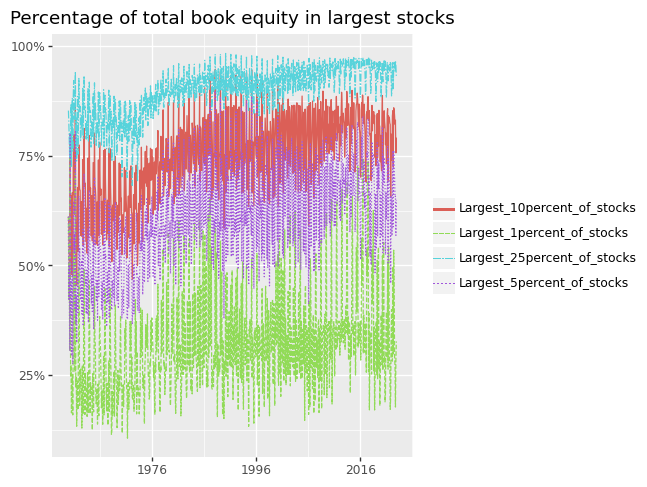

In [27]:
plot_book_equity_concentration = (ggplot(bookequity_concentration, 
                                        aes(x="date", y="value", color="type", linetype="type")) +
                                 geom_line() +
                                 scale_y_continuous(breaks=[0, 0.25, 0.5, 0.75, 1],labels=["0%", "25%", "50%", "75%", "100%"])+
                                 scale_x_datetime(breaks=date_breaks(width="20 year"), labels=date_format("%Y")) +
                                 labs(x="", y="", color="", linetype="", 
                                      title="Percentage of total book equity in largest stocks") +
                                 theme(legend_title=element_blank()))

plot_book_equity_concentration.draw()

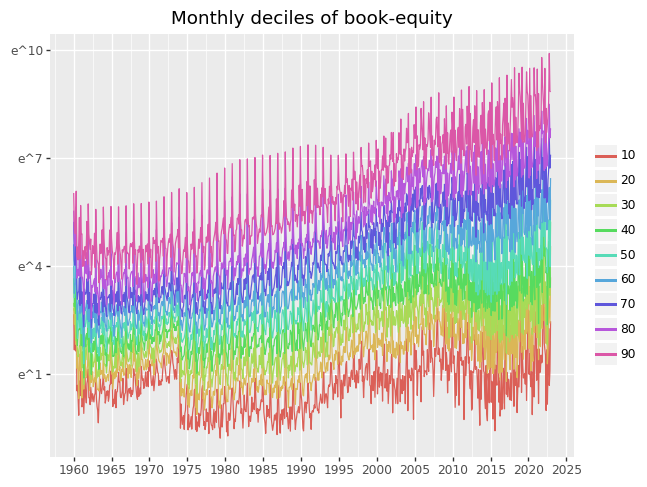

In [28]:
# 绘制断点图---账面值
be_quantiles = (book_equity
  .groupby("date")["be"]
  .quantile(q=np.arange(0.1, 1.0, 0.1))
  .reset_index()
  .rename(columns={"level_1": "quantile"})
  .assign(
    quantile=lambda x: (x["quantile"] * 100).astype(int)
  )
  .dropna()
)

plot_be_quantiles = (
  ggplot(be_quantiles, 
         aes(x="date", y="be", 
             color="factor(quantile)")) +
  geom_line() +
  scale_x_datetime(breaks=date_breaks("5 year"), 
                   labels=date_format("%Y")) +
    scale_y_continuous(trans='log')+
  labs(x="", y="", color="",
       title="Monthly deciles of book-equity")
)
plot_be_quantiles.draw()

In [29]:
data_for_sorts

,permno,gvkey,date,ret_excess,mktcap_lag,me,bm,exchange
14,10000,013007,1987-04-01,-0.066900,0.973250,0.973250,0.139225,NASDAQ
15,10000,013007,1987-05-01,-0.070467,0.912422,0.912422,0.139225,NASDAQ
26,10001,012994,1986-12-01,0.010100,6.937000,6.937000,1.166394,NASDAQ
27,10001,012994,1987-01-01,-0.039914,6.937000,6.937000,1.166394,NASDAQ
28,10001,012994,1987-02-01,-0.078374,6.689250,6.689250,1.166394,NASDAQ
...,...,...,...,...,...,...,...,...
3097032,93436,184996,2022-08-01,-0.074389,931110.623250,931110.623250,0.027663,NASDAQ
3097033,93436,184996,2022-09-01,-0.039489,863615.620800,863615.620800,0.027663,NASDAQ
3097034,93436,184996,2022-10-01,-0.144468,837659.500000,837659.500000,0.027663,NASDAQ
3097035,93436,184996,2022-11-01,-0.147226,718514.868879,718514.868879,0.027663,NASDAQ


In [30]:
bm_concentration  = (data_for_sorts
                             .get(["date","bm"]) ## 提取日期和账面市值的数据
                             .groupby("date",group_keys=False)
                             .apply(lambda x: x.assign(bm_group = lambda x: np.digitize(x["bm"], np.percentile(x["bm"], [75, 90, 95, 99]))))
                             ## 按市值的百分位数分组
                             .groupby("date",group_keys=False)
                             .apply(lambda x: x.assign(Largest_1percent_of_stocks = ((x["bm"][x["bm_group"]>=4]).sum()/x["bm"].sum()),
                                                       Largest_5percent_of_stocks = ((x["bm"][x["bm_group"]>=3]).sum()/x["bm"].sum()),
                                                       Largest_10percent_of_stocks = ((x["bm"][x["bm_group"]>=2]).sum()/x["bm"].sum()),
                                                       Largest_25percent_of_stocks = ((x["bm"][x["bm_group"]>=1]).sum()/x["bm"].sum()))
                                    .tail(1)
                                   )
                             ## 在每个分组中计算不同市值的集中度，如市值在前1%的股票的市值总和占所有股票市值总和的比例...
                             .melt(id_vars="date",
                                   value_vars=["Largest_1percent_of_stocks", "Largest_5percent_of_stocks",
                                               "Largest_10percent_of_stocks","Largest_25percent_of_stocks"],
                                   var_name="type",
                                   value_name="value")
                             )

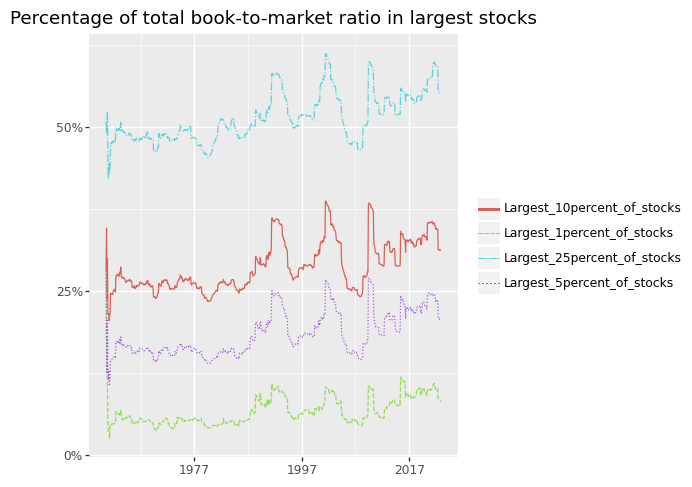

In [31]:
plot_bm_concentration = (ggplot(bm_concentration, 
                                        aes(x="date", y="value", color="type", linetype="type")) +
                                 geom_line() +
                                 scale_y_continuous(breaks=[0, 0.25, 0.5, 0.75, 1],labels=["0%", "25%", "50%", "75%", "100%"])+
                                 scale_x_datetime(breaks=date_breaks(width="20 year"), labels=date_format("%Y")) +
                                 labs(x="", y="", color="", linetype="", 
                                      title="Percentage of total book-to-market ratio in largest stocks") +
                                 theme(legend_title=element_blank()))

plot_bm_concentration.draw()

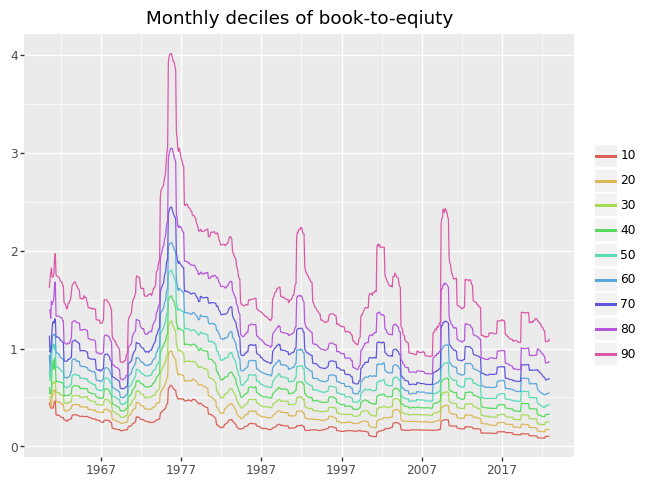

In [32]:
# 绘制断点图---账面市值比
bm_quantiles = (data_for_sorts
  .groupby("date")["bm"]
  .quantile(q=np.arange(0.1, 1.0, 0.1))
  .reset_index()
  .rename(columns={"level_1": "quantile"})
  .assign(
    quantile=lambda x: (x["quantile"] * 100).astype(int)
  )
  .dropna()
)

plot_bm_quantiles = (
  ggplot(bm_quantiles, 
         aes(x="date", y="bm", 
             color="factor(quantile)")) +
  geom_line() +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x="", y="", color="",
       title="Monthly deciles of book-to-eqiuty")
)
plot_bm_quantiles.draw()

### 2

When we investigate the portfolios, we focus on the returns exclusively. However, it is also of interest to understand the characteristics of the portfolios. Write a function to compute the average characteristics for size and book-to-market across the 25 independently and dependently sorted portfolios.

In [33]:
def ave_cha(data_for_sorts, Independent_sorts=True):
    if Independent_sorts:
        datasort = (data_for_sorts
            .groupby("date",group_keys=False, observed=False)
            .apply(lambda x: x.assign(
                portfolio_bm=assign_portfolio(
                    data=x, sorting_variable="bm", n_portfolios=5, exchanges=["NYSE"]
                ),
                portfolio_me=assign_portfolio(
                    data=x, sorting_variable="me", n_portfolios=5, exchanges=["NYSE"]
                )
            ))
            .reset_index(drop=True)
        )
    else:
        datasort = (data_for_sorts
            .groupby("date",group_keys=False, observed=False)
            .apply(lambda x: x.assign(
                portfolio_me=assign_portfolio(
                    data=x, sorting_variable="me", n_portfolios=5, exchanges=["NYSE"]
                )
            ))
            .reset_index(drop=True)
            .groupby(["date", "portfolio_me"],group_keys=False, observed=False)
            .apply(lambda x: x.assign(
                portfolio_bm=assign_portfolio(
                    data=x, sorting_variable="bm", n_portfolios=5, exchanges=["NYSE"]
                )
            ))
            .reset_index(drop=True)
        )
    ave = datasort.groupby(["portfolio_me", "portfolio_bm"]).agg(
        ave_size=("me", "mean"),
        ave_bm=("bm", "mean")
        ).reset_index()

    return ave

In [34]:
ave_cha(data_for_sorts,Independent_sorts=False)

,portfolio_me,portfolio_bm,ave_size,ave_bm
0,1,1,86.905467,0.349693
1,1,2,97.956021,0.734659
2,1,3,91.028409,1.016462
3,1,4,75.500657,1.367344
4,1,5,49.430806,2.602364
5,2,1,499.946779,0.287762
6,2,2,528.394861,0.561173
7,2,3,513.581829,0.767572
8,2,4,505.868449,1.010328
9,2,5,473.404756,1.692474


### 3

As for the size premium, also the value premium constructed here does not follow Fama and French (1993). Implement a p-hacking setup as in Size Sorts and P-Hacking to find a premium that comes closest to their HML premium.

In [35]:
def calculate_returns(data, value_weighted):
    """Calculate (value-weighted) returns."""
    if value_weighted:
        return np.average(data["ret_excess"], weights=data["mktcap_lag"])
    else:
        return data["ret_excess"].mean()

def compute_portfolio_returns(n_portfolios = 10,
                              exchanges = ["NYSE", "NASDAQ", "AMEX"],
                              Independent_sorts = True,
                              value_weighted = True,
                              data = data_for_sorts):
    """Compute (value-weighted) portfolio returns."""
    if Independent_sorts:
        datasort = (data
            .groupby("date",group_keys=False, observed=False)
            .apply(lambda x: x.assign(
                portfolio_bm=assign_portfolio(
                    data=x, sorting_variable="bm", n_portfolios=n_portfolios, exchanges=exchanges
                ),
                portfolio_me=assign_portfolio(
                    data=x, sorting_variable="me", n_portfolios=n_portfolios, exchanges=exchanges
                )
            ))
            .reset_index(drop=True)
        )
    else:
        datasort = (data
            .groupby("date",group_keys=False, observed=False)
            .apply(lambda x: x.assign(
                portfolio_me=assign_portfolio(
                    data=x, sorting_variable="me", n_portfolios=n_portfolios, exchanges=exchanges
                )
            ))
            .reset_index(drop=True)
            .groupby(["date", "portfolio_me"],group_keys=False, observed=False)
            .apply(lambda x: x.assign(
                portfolio_bm=assign_portfolio(
                    data=x, sorting_variable="bm", n_portfolios=n_portfolios, exchanges=exchanges
                )
            ))
            .reset_index(drop=True)
        )
    returns = (datasort
        .groupby(["date", "portfolio_bm", "portfolio_me"],group_keys=False, observed=False)
        .apply(lambda x: x.assign(
            ret=calculate_returns(x, value_weighted))
        )
        .reset_index(drop=True)
        .groupby("date",group_keys=False, observed=False)
        .apply(lambda x: 
            pd.Series({"value_premium": x.loc[x["portfolio_bm"].idxmin(), "ret"] -
                       x.loc[x["portfolio_bm"].idxmax(), "ret"]}))
        .reset_index(drop=True)
        .aggregate({"value_premium": "mean"})
    )
    return returns

In [36]:
import itertools
from joblib import Parallel, delayed, cpu_count
n_portfolios = [2, 5, 10]
exchanges = [["NYSE"], ["NYSE", "NASDAQ", "AMEX"]]
Independent_sorts= [True, False]
value_weighted = [True, False]
data = [data_for_sorts]
p_hacking_setup = list(itertools.product(n_portfolios, exchanges, Independent_sorts, value_weighted, data))

In [37]:
p_hacking_setup[0]

(2,
 ['NYSE'],
 True,
 True,
          permno   gvkey       date  ret_excess     mktcap_lag             me  \
 14        10000  013007 1987-04-01   -0.066900       0.973250       0.973250   
 15        10000  013007 1987-05-01   -0.070467       0.912422       0.912422   
 26        10001  012994 1986-12-01    0.010100       6.937000       6.937000   
 27        10001  012994 1987-01-01   -0.039914       6.937000       6.937000   
 28        10001  012994 1987-02-01   -0.078374       6.689250       6.689250   
 ...         ...     ...        ...         ...            ...            ...   
 3097032   93436  184996 2022-08-01   -0.074389  931110.623250  931110.623250   
 3097033   93436  184996 2022-09-01   -0.039489  863615.620800  863615.620800   
 3097034   93436  184996 2022-10-01   -0.144468  837659.500000  837659.500000   
 3097035   93436  184996 2022-11-01   -0.147226  718514.868879  718514.868879   
 3097036   93436  184996 2022-12-01   -0.370634  614814.304763  614814.304763   

In [38]:
n_cores = cpu_count() - 1

p_hacking_results = pd.Series(
    Parallel(n_jobs=n_cores)(
        delayed(compute_portfolio_returns)(n, e, s, v, d) 
        for n, e, s, v, d in p_hacking_setup
    )
)


/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
/var/folders/23/86y_dnld5b710c75xn6m9x400000gn/T/ipykernel_58512/451784267.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns.

In [39]:
p_hacking_results[0:10]

0    value_premium   -0.003298
dtype: float64
1     value_premium   -0.00525
dtype: float64
2     value_premium   -0.00162
dtype: float64
3    value_premium   -0.003628
dtype: float64
4    value_premium   -0.005587
dtype: float64
5    value_premium   -0.006451
dtype: float64
6    value_premium   -0.003394
dtype: float64
7    value_premium   -0.004259
dtype: float64
8    value_premium   -0.008026
dtype: float64
9    value_premium   -0.008174
dtype: float64
dtype: object

In [40]:
value_premium_values = p_hacking_results.apply(lambda x: x["value_premium"])

In [41]:
data = ["crsp_monthly"]
p_hacking_setup = pd.DataFrame(list(itertools.product(n_portfolios, exchanges, Independent_sorts, value_weighted, data)))
p_hacking_setup["value_premium"] = value_premium_values
p_hacking_exhibit= (p_hacking_setup
                    .rename(columns={0:"n_portfolio_choice",
                                     1:"exchanges_choice",
                                     3:"Independent sorts",
                                     2:"value_weighted_choice",
                                     4:"data"}))
p_hacking_exhibit.head(10)

,n_portfolio_choice,exchanges_choice,value_weighted_choice,Independent sorts,data,value_premium
0,2,[NYSE],True,True,crsp_monthly,-0.003298
1,2,[NYSE],True,False,crsp_monthly,-0.005250
2,2,[NYSE],False,True,crsp_monthly,-0.001620
3,2,[NYSE],False,False,crsp_monthly,-0.003628
4,2,"[NYSE, NASDAQ, AMEX]",True,True,crsp_monthly,-0.005587
5,2,"[NYSE, NASDAQ, AMEX]",True,False,crsp_monthly,-0.006451
6,2,"[NYSE, NASDAQ, AMEX]",False,True,crsp_monthly,-0.003394
7,2,"[NYSE, NASDAQ, AMEX]",False,False,crsp_monthly,-0.004259
8,5,[NYSE],True,True,crsp_monthly,-0.008026
9,5,[NYSE],True,False,crsp_monthly,-0.008174


In [42]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, con=tidy_finance)
print(tables)

                     name
0           compustat_raw
1                    fisd
2        ccmxpf_linktable
3          trace_enhanced
4       factors_ff3_daily
5               compustat
6     factors_ff3_monthly
7     factors_ff5_monthly
8              crsp_daily
9   industries_ff_monthly
10      factors_q_monthly
11       macro_predictors
12            cpi_monthly
13  crsp_monthly_copy_raw
14       crsp_monthly_raw
15           crsp_monthly
16                   beta


In [43]:
hml = (pd.read_sql_query(
    sql=("SELECT hml FROM factors_ff3_daily"),
    con=tidy_finance)
  .dropna()
)

In [44]:
hml

,hml
0,0.0070
1,0.0054
2,0.0038
3,0.0009
4,0.0010
...,...
15853,0.0116
15854,0.0142
15855,-0.0029
15856,-0.0107


In [45]:
p_hacking_exhibit["hml"]  = (hml)["hml"].mean()
(p_hacking_exhibit
 .assign(difference = lambda x: abs(x["hml"]-x["value_premium"])) # 市账比溢价与ff的hml溢价求差
 .sort_values("difference")).head(10)

,n_portfolio_choice,exchanges_choice,value_weighted_choice,Independent sorts,data,value_premium,hml,difference
2,2,[NYSE],False,True,crsp_monthly,-0.001620,0.000157,0.001777
0,2,[NYSE],True,True,crsp_monthly,-0.003298,0.000157,0.003455
6,2,"[NYSE, NASDAQ, AMEX]",False,True,crsp_monthly,-0.003394,0.000157,0.003551
3,2,[NYSE],False,False,crsp_monthly,-0.003628,0.000157,0.003785
7,2,"[NYSE, NASDAQ, AMEX]",False,False,crsp_monthly,-0.004259,0.000157,0.004417
15,5,"[NYSE, NASDAQ, AMEX]",False,False,crsp_monthly,-0.004722,0.000157,0.004880
14,5,"[NYSE, NASDAQ, AMEX]",False,True,crsp_monthly,-0.004820,0.000157,0.004977
10,5,[NYSE],False,True,crsp_monthly,-0.004938,0.000157,0.005095
1,2,[NYSE],True,False,crsp_monthly,-0.005250,0.000157,0.005408
11,5,[NYSE],False,False,crsp_monthly,-0.005587,0.000157,0.005744
